<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Documentation</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">20th December, 2018</span>
</div><h1>RecDynapSE:</h1><h1>Layer using the DynapSE chip</h1>

This document illustrates how to use the `RecDynapSE` layer, that runs directly on the DynapSE.

##### Housekeeping and import statements


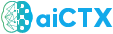

In [1]:
# - Initialisation code to include custom report styles
from IPython.core.display import HTML
def css_styling():
    styles = open("aictx-report.css", "r").read()
    return HTML(styles)
css_styling()

## Hardware basics
The layer uses the DynapSE processor, which consists of 4 chips. Each chips has 4 cores of 256 neurons. The chips, as well as each core in a chip and each neuron in a core are identified with an ID between 0 and 3 or 0 and 256, respectively. However, for this layer the neurons are given logical IDs from 0 to 4095 that range over all neurons. In other words the logical neuron ID is $1024 \cdot \text{ChipID} + 256 \cdot \text{CoreID} + \text{NeuronID}$.

<br>


## Setup

<br>

### Connecting to Cortexcontrol

In order to work interface the DynapSE chip, this layer relies on `cortexcontrol`. It should be accessed via an `RPyC` connection. In order to run some examples from within this jupyter notebook, we will do the latter. For this we start `cortexcontrol` and run the following commands in its console (not in this notebook):

If the `cortexcontrol` console prints <br>
<i>"RPyC: Ready to start."</i> <br>
and nothing else, it is ready.

### Using DynapseControl

The `RecDynapSE` layer uses a `DynapseControl` object to interact with `Cortexcontrol` (see .... for more details). You can either pass an existing `DynapseControl` object to the layer upon instantiation, or let the layer create such an object. Either way, it can be accessed via the layer's `controller` attribute.

<br>

## Import

Import the class with the following command:

In [2]:
# - Import recurrent RecDIAF layer
from NetworksPython.layers import RecDynapSE

/home/felix/miniconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


dynapse_control: RPyC connection established.
dynapse_control: CtxDynapse modules loaded.
dynapse_control: Initializing hardware.
dynapse_control: Hardware has already been initialized.


This might take a while until the `dynapse_control` module has prepared the hardware.

<br>

## Instantiation
`RecDynapSE` objects have many instantiation arguments in common with other `NetworksPython` objects, in partuclar recurrent layers such as `RecIAFTorch`, `RecIAFBrian` or `RecDIAF`. Other arguments are related to how the hardware is used and therefore unique to this layer.

| Argument | Type | Default | Meaning |
|----------|------|---------|---------|
| `mfWIn` | 2D-`ndarray`| - | Input weights (required) |
| `mfWRec` | 2D-`ndarray` | - | Recurrent weights (required) |
| `vnLayerNeuronIDs` | 1D-`ArrayLike` | `None` | IDs of the layer neurons |
| `vnVirtualNeuronIDs` | 1D-`ArrayLike` | `None` | IDs of the virtual (input) neurons |
| `tDt` | `float` | `2e-5` | Time step |
| `nMaxTrialsPerBatch` | `int` | `None` | Maximum number of trials in individual batch |
| `tMaqxBatchDur` | `float` | `None` | Maximum duration time of individual batch |
| `nMaxNumTimeSteps` | `int` | `None` | Maximum number of time steps in individual batch |
| `nMaxEventsPerBatch` | `int` | `None` | Maximum number of input Events during individual batch |
| `lInputCoreIDs` | `ArrayLike` | `[0]` | IDs of cores that receive input spikes |
| `nInputChipID` | `int` | 0 | Chip that receives input spikes |
| `lnClearCores` | `ArrayLike` | `None` | IDs of cores to be reset |
| `controller` | `DynapseControl` | `None` | `DynapseControl` instance |
| `strName` | `str` | "unnamed" | Layer name |

`mfWIn` and `mfWRec` are the input and recurrent weights and have to be provided as 2D-arrays. `mfWIn` determines the layer's dimensions `nSIzeIn` and `nSize`. `mfWRec` has to be of size `nSize` x `nSize`. Each weight must be an integer (positive or negative). Furthermore, the sum over the absolute values of the elements in any given column in `mfWIn` plus the sum over the absolute values of elements in the corresponding column of `mfWRec` must be les or equal to 64. $\sum_{i} |$ `mfWIn`$ _{ik}| + \sum_{j}|$ `mfWRec`$ _{jk}| \leq 64 \ \forall k$. This is due to limitations of the hardware and cannot be circumvented.

The layer neurons of `RecDynapSE` objects directly correspond to physical neurons on the chip. Inputs are sent to the hardware through so-called virtual neurons. Each virtual neuron has an ID, just like a physical neuron. Each input channel of the layer corresponds to such a virtual neuron. 

You can choose which physical and virtual neurons are used for the layer by passing their IDs in `vnLayerNeuronIDs` and `vnVirtualNeuronIDs`, which are 1D array-like objects with integers between 0 and 1023 or 0 and 4095, respectively. All neurons with IDs from $j \cdot 256$ to $(j+1) \cdot 256, \ j \in {0,1,..15}$ belong to the same core (with core ID $j \ mod \ 4$). All neurons with IDs from $j \cdot 1024$ to $ (j+1) \cdot 1024, \ j \in {0,..,4}$ belong to same chip (with chip ID $j$). With this in mind you can allocate neurons to specific chips and cores. 

<!---The n-th entry of `vnLayerNeuronIDs` corresponds to n-th layer neuron, the n-th entry of `vnVirtualNeurons` corresponds to the n-th input channel of the layer. As described below, under <i>Neurons</i>, it is recommended that the IDs of the physical neurons be all different to the IDs of the virtual neurons. If these arguments are `None`, the neurons will be automatically allocated. -->

In order for the to layer to function as expected you should stick to the following two rules:
- <b> Neurons that receive external input should be on different cores than  neurons that receive input from other layer neurons. As a consequence, each neuron should not receive both types of input.</b> The cores with neurons that receive external inputs are set with `lnInputCoreIDs`.
- <b> All neurons that receive external input should be on the same chip.</b> This chip is set with `nInputChipID` and is 0 by default.


<b>These rules are quite restrictive and it is possible to set them less strictly. Contact Felix if needed. </b>

`tDt` is a positive `float` that on the one hand sets the discrete layer evolution timestep, as in other layers, but on the other hand also corresponds to the smallest (nonzero) interval between input events that are sent to the chip. It needs to be larger than $1.11 \cdot 10^{-9}$ (seconds). Below, under <i>Choosing tDt</i> you can find some more thoughts on how to choose this value.

Evolution is automatically split into batches, the size of which is determined by `nMaxEventsPerBatch`, `nMaxNumTimeSteps`, `tMaxBatchDur` and `nMaxTrialsPerBatch`, which control the maximum number of events, number of timesteps, duration or number of trials in a batch.  All of them can be set to `None`, which corresponds to setting no limit, except for `nMaxEventsPerBatch`, where the limit will be set to 65535. If both `nMaxNumTimeSteps` and `tMaxBatchDur` are not `None`, the `tMaxBatchDur` will be ignored. `nMaxTrialsPerBatch` will only have an effect when the input time series to the `evolve` method contains a `vtTrialStarts` attribute. For more details on how evolutions are split into batches see <i>Evolution in batches</i>.

The list `lnClearCores` contains the IDs of the cores where (presynaptic) connections should be reset on instantiation. Ideally this contains all the cores that are going to be used for this `RecDynapSE` object. However, if you want to save time and you know what you are doing you can set this to `None`, so no connections are reset.

You can pass an existing `DynapseControl` instance to the layer that will handle the interactions with `Cortexcontrol`. If this argument is `None`, a new `DynapseControl` will be instantiated.

`strName` is a `str` that defines the layer's name. 

All of these values can be accessed and changed via `<Layer>.value`, where `<Layer>` is the instance of the layer.

<br>

### Example
We can set up a simple layer on the chip by only passing input weights and recurrent weights. The weights are chosen so that there is a population of 3 "input neurons" that receive the input and then excite the remaining 6 neurons, which are recurrently connected. This way the constraints mentioned above are satisfied.

In [3]:
import numpy as np

# - Weight matrices: 3 neurons receive external input 
#   from 2 channels and stimulate the remaning
#   6 neurons, which are recurrently connected.

mfWIn = np.zeros((2,9))
# Only first 3 neurons receive input
mfWIn[:,:3] = np.random.randint(-2, 2, size=(2,3))

mfWRec = np.zeros((9,9))
# Excitatory connections from input neurons to rest
mfWRec[:3, 3:] = np.random.randint(3, size=(3,6))
# Recurrent connecitons between remaining 6 neurons
mfWRec[3:, 3:] = np.random.randint(-2, 2, size=(6,6))

rlRec = RecDynapSE(mfWIn, mfWRec, strName="example-layer")


DynapseControl: Initializing DynapSE
DynapseControl: Spike generator module ready.
DynapseControl: Time constants of cores range(0, 16) have been reset.
DynapseControl: Neurons initialized.
	 4092 hardware neurons and 4092 virtual neurons available.
DynapseControl: Neuron connector initialized
DynapseControl: Connections to cores None have been cleared.
DynapseControl: FPGA spike generator prepared.
DynapseControl ready.
Layer `example-layer`: Superclass initialized
Layer `example-layer`: Layer neurons allocated
Layer `example-layer`: Virtual neurons allocated
DynapseControl: Excitatory connections of type `FAST_EXC` from virtual neurons to hardware neurons have been set.
DynapseControl: Inhibitory connections of type `FAST_INH` from virtual neurons to hardware neurons have been set.
Layer `example-layer`: Connections to virtual neurons have been set.
DynapseControl: Excitatory connections of type `FAST_EXC` between hardware neurons have been set.
DynapseControl: Inhibitory connections

## Choosing tDt
As with all layers, a `RecDynapSE` object's evolution takes place in discrete time steps. This allows to send an `nNumTimeSteps` argument to the `evolve` method, which is consistent with other layer classes and important for the use within a `Network`. Besides, event though the hardware evolves in continuous time, the input events use discrete timesteps. These timesteps are $\frac{10^{-7}}{9} \text{ s} = 11.\bar{1} \cdot 10^{-9} \text{ s}$ and mark the smallest value that can be chosen for the layer timestep `tDt`.

Although the effect the timestep size has on computation time is much smaller than with other layers, it is not always advisable to choose the smallest possible value. The reason is that the number of timesteps between two input spikes is currently limited to $2^{16}-1 = 65535$. This means that with tDt $= 11.\overline{1} \cdot 10^{-9} \text{ s}$, any section in the  input signal without input spikes longer than about 0.73 milliseconds will cause the layer to throw an exception. Therefore it makes sense to set `tDt` to something between $10^{-6}$ and $10^{-4}$ seconds, in order to allow for sufficiently long silent parts in the input while still maintaining a good temporal resolution.

<b>If these limitations are causing problems contact Felix so that he can implement a way around it.</b>

<br>

## Neurons

The layer neurons of `RecDynapSE` objects directly correspond to physical neurons on the chip. Inputs are sent to the hardware through so-called virtual neurons. Each input channel of the layer corresponds to such a virtual neuron. Every neuron on the DynapSE has a logical ID, which ranges from 0 to 4095 for the physical and from 0 to 1023 for the virtual neurons. 

<!--- (probably not necessary) An input spike to the layer translates to a virtual neuron emitting a spike. If a neuron is set to receive spikes from a neuron with ID $n$, it makes no difference if a virtual or a pysical neuron with this ID is firing. The target neuron will receive the spikes in both cases. Because this can cause unexpected behavior it is recommended that the IDs of the physical neurons are pairwise different from the IDs of of the virtual neurons.
--> 

<br> 

### Neuron states
Hardware neurons' states change constantly according to the laws of physics, even when the layer is currently not evolving, and there is no state variable that could be read out for all neurons simultaneously. Therefore the `RecDynapSE` has no state vector like other layer classes. The `vState` attribute is just a 1D array of `nSize` zeros.

<br>

## Synapses

There are four different synapse types on the DynapSE: fast and slow excitatory as well as fast and slow inhibitory. Each neuron can receive inputs through up to 64 synapses, each of which can be any of the given types. Via `cortexcontrol` the synaptic behavior can be adjusted for each type and for each core, but not for individual synapses.

There is a priori no difference between slow and fast excitatory synapses, so they can be set to have the same behavior. In fact, one could assign shorter time constants to the "slow" excitatory synapses, making them effectively the fast ones. While both excitatory and the fast inhibitory synapses work by adding or subtracting current to the neuron membrane, the slow inhibitory synapses use shunt inhibition and in practice silence a neuron very quickly.

Note that all synapses that are of the same type and that are on the same core have the same weight. Different connection strengths between neurons can only be achieved by setting the same connection multiple times. Therefore the weight matrices `mfWIn` and `mfWRec` can only be positive or negative integers and thus determine the number of excitatory and inhibitory connections to a neuron.

In this layer the connections from external input to layer neurons are fast excitatory or inhibitory synapses. Outgoing connections from neurons that receive external input are fast excitatory or inhibitory. Outgoing connecitons from other neurons are slow excitatory and fast inhibitory. For different configurations the `_compile_weights_and_configure` method has to be modified.  Felix can help you with this.

<br>

## Evolution

The `evolve` method takes the standard arguments `tsInput`, `tDuration`, `nNumTimeSteps` and `bVerbose`, which is currently not being used. Evolution duration is determined by the usual rules. If `tsInput` is provided, it must be a `TSEvent` object.

The input is sent to the hardware neurons which will evolve and spike. The neurons' spikes are collected in a `TSEvent` object with the timings and IDs of the spiking neurons. 

Note that the hardware neurons continue evolving, so in contrast to software simulations, the layer will be in a different state (membrane potentials etc.) when an evolution begins than when the previous evolution ended. Because evolution happens in batches, this even happens between some of the timesteps within the evolution (see below).

<br>

### Evolution in batches
As for now it is not possible to stream events (input spikes) continuously to the DynapSE. Therefore a group of events is transferred to the hardware, temporarily stored there and then translated to spikes of virtual neurons, with temporal order and inter-spike intervals matching the input signal.

The number of events that can be sent at once is limited. To allow for arbitrarily long layer evolution times, the input can be split into batches, during each of which a number of events is sent and "played back" to the hardware.

There are two ways of splitting the full input signal into batches. First, a new batch ends, as soon as it contains the maximum number of spikes or lasts the maximum allowed batch duration. These values can be set for each `RecDynapSE` object and are stored in the `nMaxEventsPerBatch` and `tMaxBatchDur` attributes. While the former is limited by the hardware to be at most $2^{16}-1 = 65535$, the latter can be set to `None`, which in principle allows for arbitrarily long batch durations. However, the length of any inter-spike interval is currently limited, too, so effectively the batch duration is limited also in this case (see <i>Choosing tDt</i> for more details).

Note that because the hardware neurons keep evolving after a batch ends, their state (membrane potentials etc.) will have changed until the next batch starts. These discontinuities could be problematic for some simulations. In particular if the input data consists of trials, no trial should be divided over two batches.

The second way of splitting batches considers this scenario and by splitting the input only at the beginnings of trials. The number of trials in a batch is determined by the layer's `nMaxTrialPerBatch` attribute. If a batch with this number of trials contains more events or lasts longer than allowed, the number of trials is reduced accordingly. This method is used if the input time series has a `vtTrialStarts` attribute, that indicates the start time of each trial, and if `nMaxTrialsPerBatch` is not `None`.

<br> 

## Resetting

As usual the layer's time and state can be reset by the `reset_time`, `reset_state` and `reset_all` methods. However, since there is no state vector in this class, `reset_state` has no effect and `reset_all` effectively does the same as `reset_time`.

<br>

## Internal methods

```
_batch_input_data(
    self, tsInput: TSEvent, nNumTimeSteps: int, bVerbose: bool = False
) -> (np.ndarray, int)
```
This mehtod is called by evolve, which passes it the evolution input `tsInput` and the number of evolution timesteps `nNumTimeSteps`. It splits the input into batches according to the maximum duration, number of events and number of trials and returns a generator that for each batch yields the timesteps and channels of the input events in the batch, the time step at which the batch begins and teh duration of the batch.

```
_compile_weights_and_configure(self)
```
Configures the synaptic connections on the hardware according to the layer weights.

<br>

## Class member overview

<br>

### Methods
| Method | Description |
|--------|-------------|
| `_batch_input_data` | Split evolution into batches and return generator | `_compile_weights_and_configure` | Configure hardware synaptic connections.
| `evolve` | Evolve layer |
| `reset_all` | Reset layer time to 0|
| `reset_state` | Do nothing. |
| `reset_time` | Reset layer time to 0 |

<i> Internal methods of parent class</i> `Layer` <i> are listed in corresponding documentation. </i>

<br>

### Attributes

Each argument that described in section Instantiation has a corresponding attribute that can be accessed by `<Layer>.<attribute>`, where `<Layer>` is the layer instance and `<attribute>` the argument name. Furthermore there are a few internal attributes:

| Attribute name | Description |
|----------------|-------------|
| `_vHWNeurons` | 1D-Array of hardware neurons used for the layer. |
| `vVirtualNeurons` | 1D-Array of virtual neurons used for the layer. |

#### Colophon
Live notebook requires a Jupyter Notebook server.

GitLab repository location: https://gitlab.com/ai-ctx/network-architectures/blob/master/Projects/Documentation/FFCLIAF%20and%20RecCLIAF.ipynb